In [1]:
#!pip install keras
#!pip install --upgrade keras
#!pip install tensorflow
#!pip install --upgrade tensorflow
#!pip install matplotlib-venn
#!pip uninstall numpy -y
#!pip install numpy==1.22.4
#!pip install scipy

# Libraries

In [2]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Data

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = value.split("/")
    filename = parts[-1].split(".")[0]
    numeric_part = ''.join(filter(str.isdigit, filename))
    return int(numeric_part)

In [4]:
from PIL import Image
import numpy as np
from glob import glob

desired_width = 256
desired_height = 192

def numericalSort(value):
    parts = value.split("/")
    filename = parts[-1].split(".")[0]
    numeric_part = ''.join(filter(str.isdigit, filename))
    return int(numeric_part)

filelist_trainx = sorted(glob('/kaggle/input/data-baru/dataset_baru/test/*.jpg'), key=numericalSort)

X_train = []
for fname in filelist_trainx:
    img = np.array(Image.open(fname).convert('RGB').resize((desired_width, desired_height)))
    X_train.append(img)

x_train = np.array(X_train)
x_test = np.array(X_train)
x_val = np.array(X_train)

filelist_trainy = sorted(glob('/kaggle/input/data-baru/dataset_baru/Label/*.png'), key=numericalSort)
y_train = np.array([np.array(Image.open(fname).convert('RGB').resize((desired_width, desired_height))).reshape((desired_height, desired_width, 3)) for fname in filelist_trainy])
y_test = np.array([np.array(Image.open(fname).convert('RGB').resize((desired_width, desired_height))).reshape((desired_height, desired_width, 3)) for fname in filelist_trainy])
y_val = np.array([np.array(Image.open(fname).convert('RGB').resize((desired_width, desired_height))).reshape((desired_height, desired_width, 3)) for fname in filelist_trainy])


print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (252, 192, 256, 3)
y_train shape: (252, 192, 256, 3)
x_test shape: (252, 192, 256, 3)
y_test shape: (252, 192, 256, 3)
x_val shape: (252, 192, 256, 3)
y_val shape: (252, 192, 256, 3)


**original images**

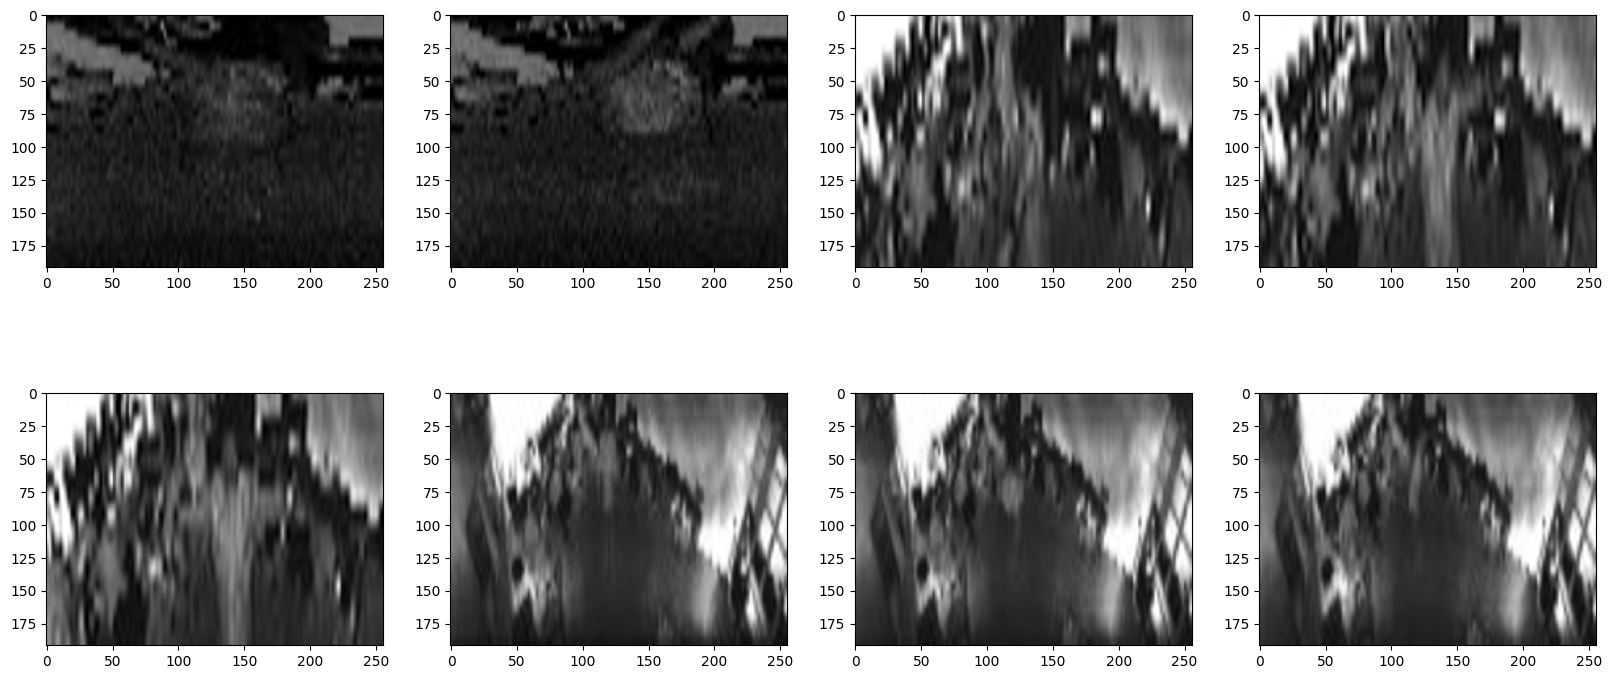

In [5]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(x_train[0])
plt.subplot(2,4,2)
plt.imshow(x_train[35])
plt.subplot(2,4,3)
plt.imshow(x_train[80])
plt.subplot(2,4,4)
plt.imshow(x_train[134])
plt.subplot(2,4,5)
plt.imshow(x_train[159])
plt.subplot(2,4,6)
plt.imshow(x_train[185])
plt.subplot(2,4,7)
plt.imshow(x_train[201])
plt.subplot(2,4,8)
plt.imshow(x_train[243])
plt.show()

**Masked Image**

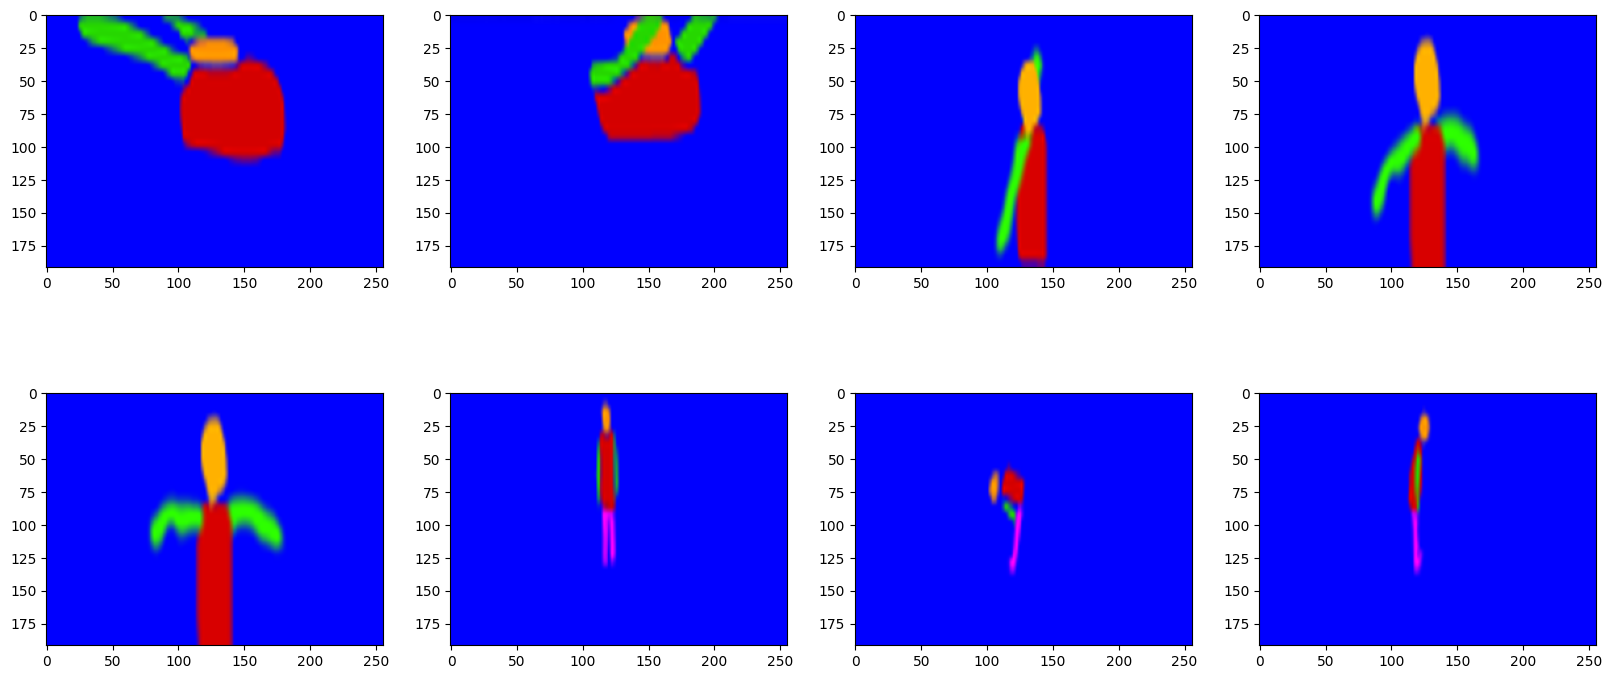

In [6]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(y_train[35], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(y_train[80], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(y_train[134], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(y_train[159], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(y_train[185], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(y_train[201], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(y_train[243], cmap = plt.cm.binary_r)
plt.show()

# Defining Evaluation Metrics

**Precision**

In [7]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

**Recall**

In [8]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

**Accuracy**

In [9]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [10]:
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

**Checking training set, test set, validation set**

In [11]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 252
Length of the Test Set       : 252
Length of the Validation Set : 252


# Model SegNet (Convolutional Encoder - Decoder)

In [12]:
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(3, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256,3))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer=Adam(lr=0.0001), loss="categorical_crossentropy", metrics=[iou, precision, recall, accuracy])

    model.summary()
    hist = model.fit(x_train, y_train, epochs=epochs_num, batch_size=18, validation_data=(x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

**After 1 epoch**

In [13]:
model, hist = segnet(1, 'segnet_1_epoch.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 192, 256, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 192, 256, 64)      256       
                                                                 
 activation (Activation)     (None, 192, 256, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 192, 256, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 192, 256, 64)      256       
                                                                 
 activation_1 (Activation)   (None, 192, 256, 64)      0     

In [14]:
# Encoding layer
img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)
# Decoding Layer 
x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(3, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256,3))(x)

In [15]:
model_0 = Model(inputs=img_input, outputs=pred)

model_0.compile(optimizer= Adam(lr=0.0001), loss= ["categorical_crossentropy"], metrics=[precision, recall, accuracy])

In [16]:
model_0.load_weights('segnet_1_epoch.h5')

In [17]:
model, hist = segnet(epochs_num= 500, savename= 'segnet_500_epoch.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 192, 256, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 192, 256, 64)      256       
                                                                 
 activation_52 (Activation)  (None, 192, 256, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 192, 256, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 192, 256, 64)      256       
                                                                 
 activation_53 (Activation)  (None, 192, 256, 64)      0   

In [18]:
model_1 = Model(inputs=img_input, outputs=pred)
model_1.compile(optimizer= Adam(lr=0.0001), loss= ["categorical_crossentropy"], metrics=[precision, recall, accuracy])

In [19]:
model_1.load_weights('segnet_500_epoch.h5')

In [20]:
print('\n~~~~~~~~~~~~~~~Segmentation Result~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('Precision: |   {:.2f}  |'.format(res[1]))
print('Recall:    |   {:.2f}  |'.format(res[2]))
print('Accuracy:  |   {:.2f}  |'.format(res[3]))
print("Loss:      |   {:.2f}  |".format(res[0]))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('Precision: |   {:.2f}  |'.format(res[1]))
print('Recall:    |   {:.2f}  |'.format(res[2]))
print('Accuracy:  |   {:.2f}  |'.format(res[3]))
print("Loss:      |   {:.2f}  |".format(res[0]))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('Precision: |   {:.2f}  |'.format(res[1]))
print('Recall:    |   {:.2f}  |'.format(res[2]))
print('Accuracy:  |   {:.2f}  |'.format(res[3]))
print("Loss:      |   {:.2f}  |".format(res[0]))
print('________________________')


~~~~~~~~~~~~~~~Segmentation Result~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

14/14 [==============================] - 5s 232ms/step - loss: 17.9433 - precision: 1.0674 - recall: 0.9730 - accuracy: 0.6211
________________________
Precision: |   1.07  |
Recall:    |   0.97  |
Accuracy:  |   0.62  |
Loss:      |   17.94  |
________________________

-------------On Test  Set--------------------------

14/14 [==============================] - 3s 235ms/step - loss: 17.9433 - precision: 1.0674 - recall: 0.9730 - accuracy: 0.6211
________________________
Precision: |   1.07  |
Recall:    |   0.97  |
Accuracy:  |   0.62  |
Loss:      |   17.94  |
________________________

-------------On validation Set---------------------

14/14 [==============================] - 3s 235ms/step - loss: 17.9433 - precision: 1.0674 - recall: 0.9730 - accuracy: 0.6211
________________________
Precision: |   1.07  |
Recall:    |   0.97  |
Accuracy:  |   0.62  |
Loss:      |   17.94  

# Visualisasi Prediksi

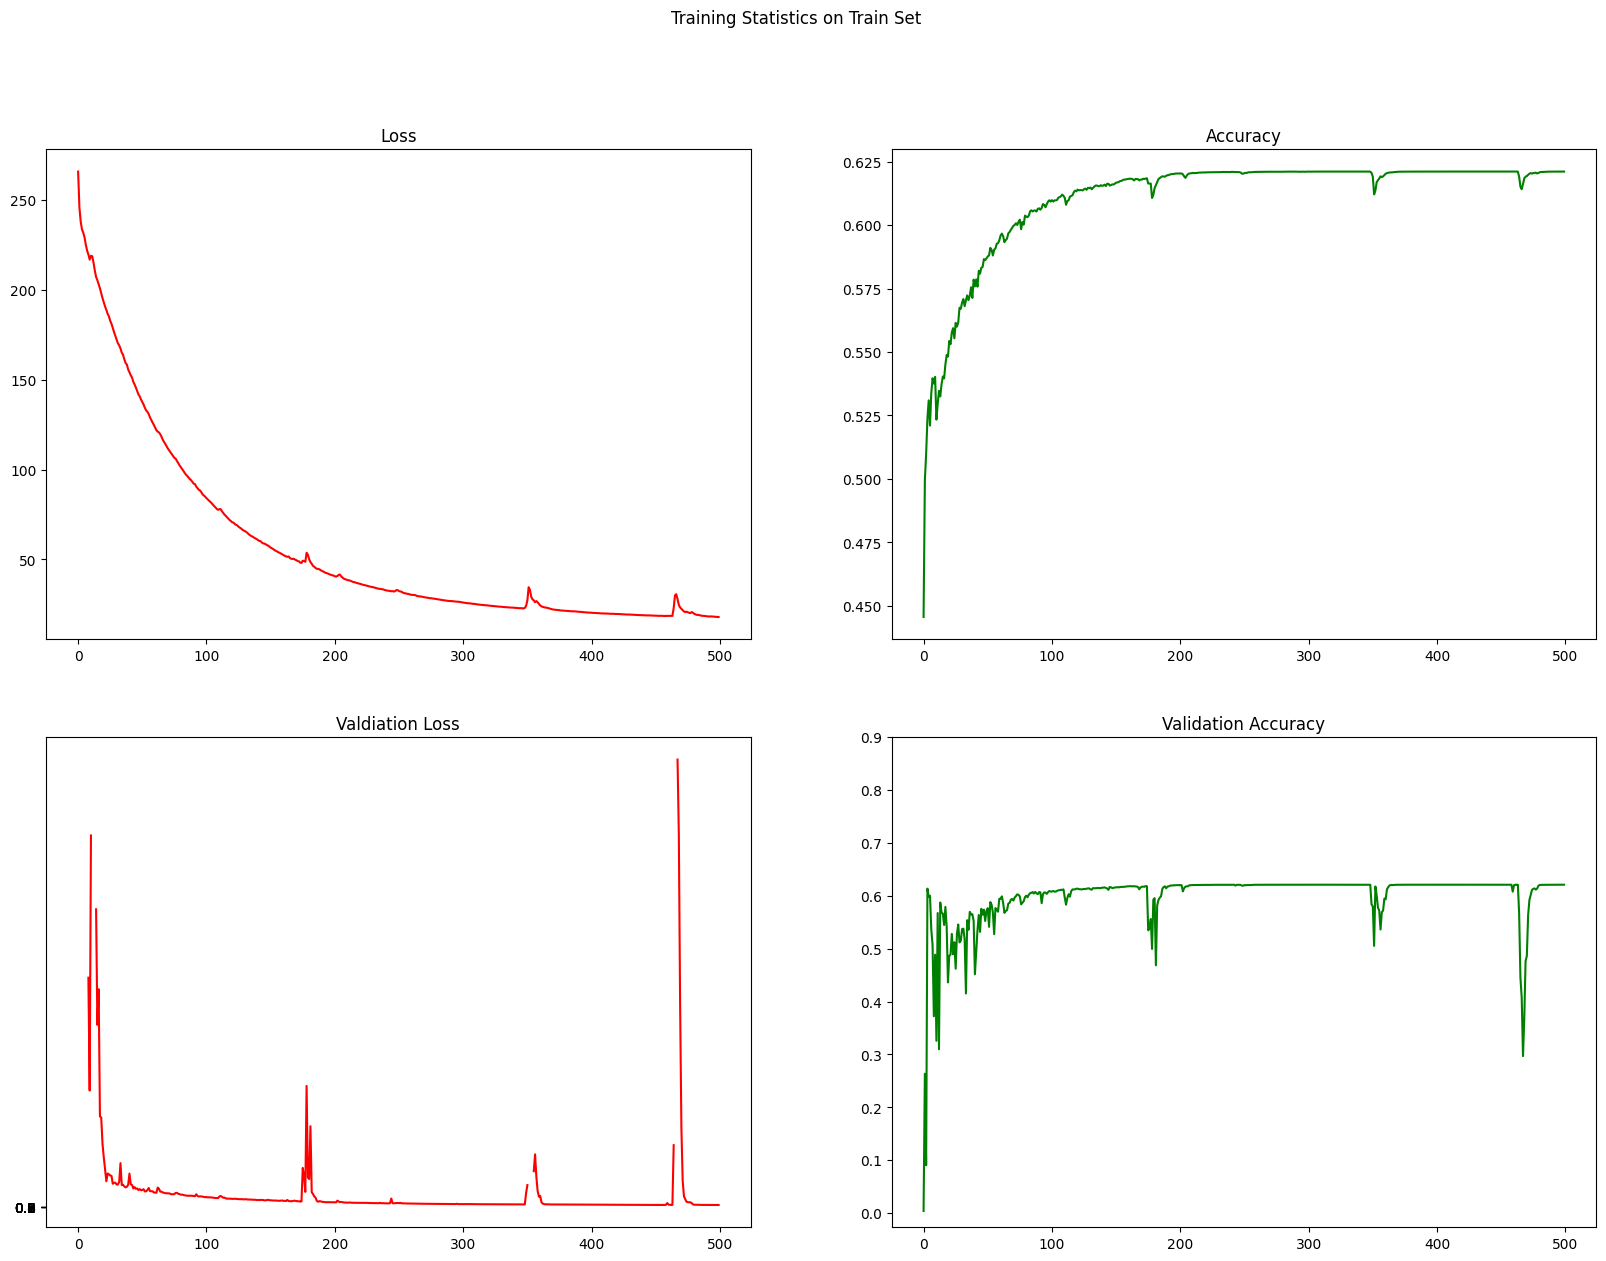

In [21]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

1/1 [==============================] - 2s 2s/step


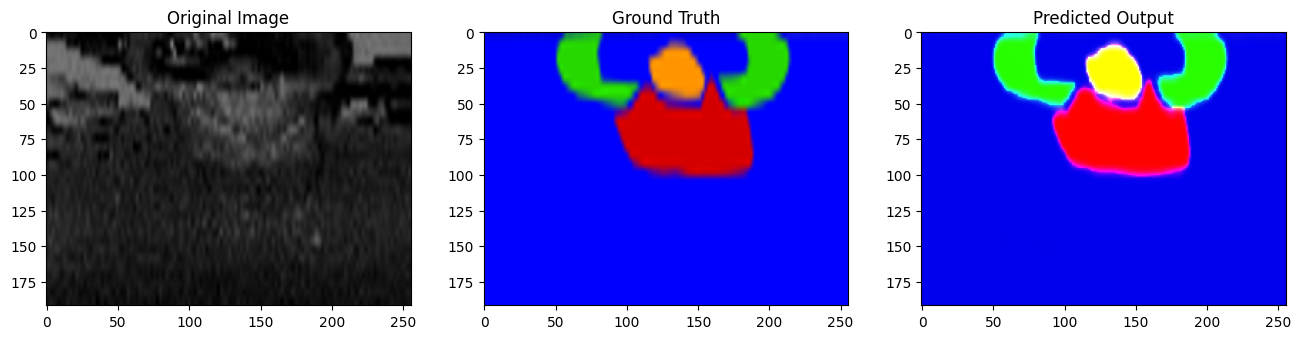

In [22]:
img_num = 60
img_pred = model_0.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256, 3), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 34ms/step


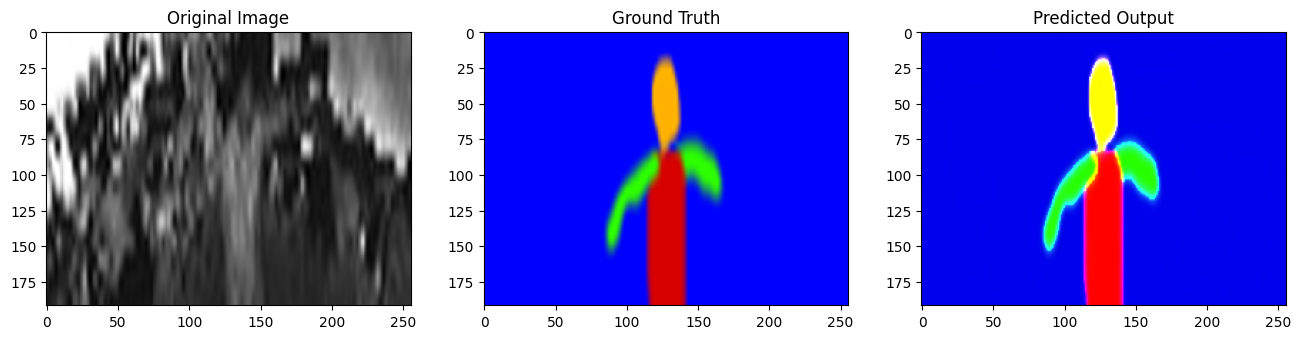

In [23]:
img_num = 134
img_pred = model_0.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256, 3), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 34ms/step


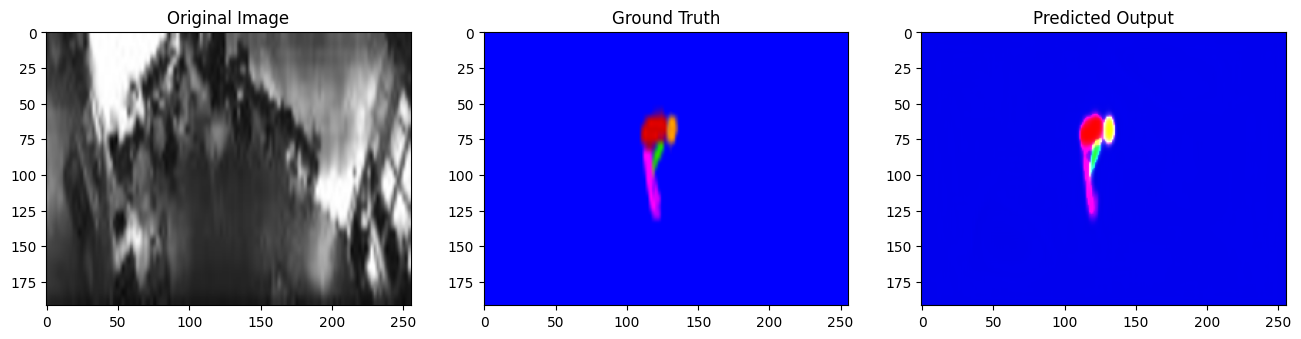

In [24]:
img_num = 225
img_pred = model_0.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256, 3), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()